# Plots for ML4O2 products
- enter the version to plot
- plots RMSE and Correlation from test data
- plots annual and seasonal climatology, and offsets from WOA18

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import joblib

In [2]:
ver = '2.1.1.1.1.1'

### RMSE and R value

In [3]:
selection = ver.split('.')
basin = ['Atlantic','Pacific','Indian','Southern','Arctic']
#
if selection[0] == '1':
    print('Random Forst algorithm')
    alg = 'Random forest'
elif selection[0] == '2':
    print('Neural Network algorithm')
    alg = 'Neural network'
else:
    print('error - incorrect algorithm type')
#
if selection[1] == '1':
    print('Ship-based O2 data')
    src='Ship only'
elif selection[1] == '2':
    print('Ship-based and Argo-O2 data')
    src='Ship + Argo'
else:
    print('error - incorrect input data type')
#
if selection[2] == '1':
    print(basin[int(selection[2])-1]+' Ocean')
elif selection[2] == '2':
    print(basin[int(selection[2])-1]+' Ocean')
elif selection[2] == '3':
    print(basin[int(selection[2])-1]+' Ocean')
elif selection[2] == '4':
    print(basin[int(selection[2])-1]+' Ocean')
elif selection[2] == '5':
    print(basin[int(selection[2])-1]+' Ocean')
else:
    print('error - incorrect O2 data type')
ocn=basin[int(selection[2])-1]
#
if selection[3] == '1':
    print('EN4 dataset will be used for T/S input. ')
else:
    print('error - incorrect T/S data type')
#
if selection[4] == '1':
    print('Predictor variables include T, S, lon, lat, depth (pressure), year, month')
else:
    print('error - incorrect predictor variable type')
#
if selection[5] == '1':
    print('Hyperparameter set is optimized via K-fold CV')
else:
    print('error - incorrect hyperparameter type')

Neural Network algorithm
Ship-based O2 data
Atlantic Ocean
EN4 dataset will be used for T/S input. 
Predictor variables include T, S, lon, lat, depth (pressure), year, month
Hyperparameter set is optimized via K-fold CV


### Display the results from hyperparameter tuning

the best performing configuration ={'alpha': 0.001, 'hidden_layer_sizes': [40, 40, 40, 40]}


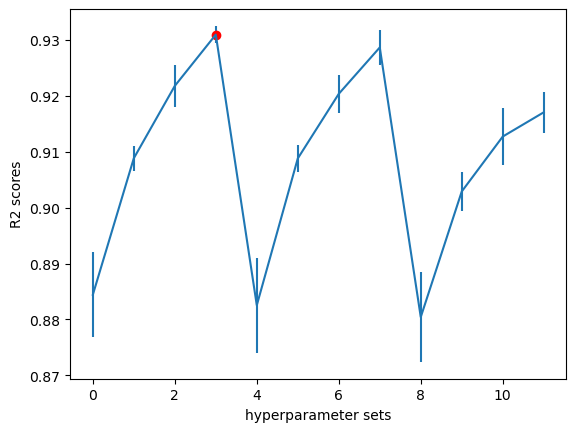

In [4]:
# read in the algorithm file
dirout='/glade/campaign/univ/ugit0034/ML4O2_results/'
MLmodel = joblib.load(dirout+f'algorithm_v{ver}.sav')
scores = MLmodel.cv_results_['mean_test_score']
sigscore = MLmodel.cv_results_['std_test_score']
Ncv=np.size(scores)
# display the result
plt.errorbar(range(Ncv),scores,sigscore*2)
plt.xlabel('hyperparameter sets')
plt.ylabel('R2 scores')
I=np.argmax(scores)
plt.plot(I,scores[I],'ro')
print('the best performing configuration ='+str(MLmodel.cv_results_['params'][I]))

Text(50, 375, 'RMSE=15.46')

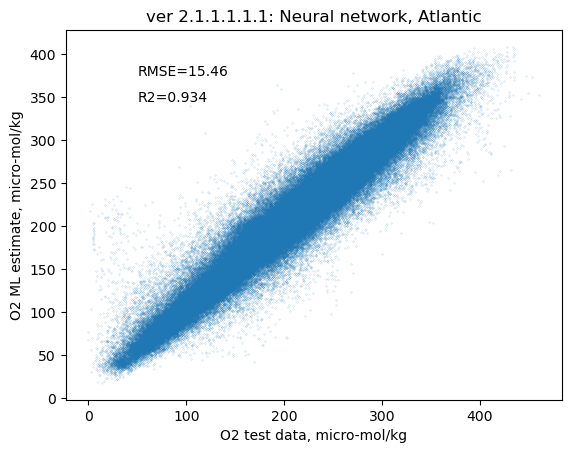

In [5]:
test = np.load(f'/glade/campaign/univ/ugit0034/ML4O2_results/o2test_pred_v{ver}.npz')
o2est = test['est']
o2test= test['test']
#
plt.plot(o2test,o2est,'.',markersize=.2)
plt.xlabel('O2 test data, micro-mol/kg')
plt.ylabel('O2 ML estimate, micro-mol/kg')
plt.title('ver '+ver+': '+alg+', '+ocn)
#
tmp=np.corrcoef(o2est,o2test)
R2 = tmp[0,1]**2
#
RMSE = np.sqrt(np.mean((o2est-o2test)**2))
#
plt.text(50,345,'R2='+str(R2)[:5])
plt.text(50,375,'RMSE='+str(RMSE)[:5])

### Read in World Ocean Atlas 2018 climatology for comparison

In [6]:
dc=xr.open_mfdataset('/glade/campaign/univ/ugit0034/woa18/monthly/woa18_all_o*',decode_times=False)

### Read in Gridded O2 data

In [7]:
ds=xr.open_dataset(f'/glade/campaign/univ/ugit0034/ML4O2_results/O2map_v{ver}.nc')

In [8]:
do2 = ds.o2est.groupby('time.month').mean('time').isel(depth=0).to_numpy()-dc.o_an.isel(depth=0).to_numpy()

### Monthly climatology of ML estimates at surface

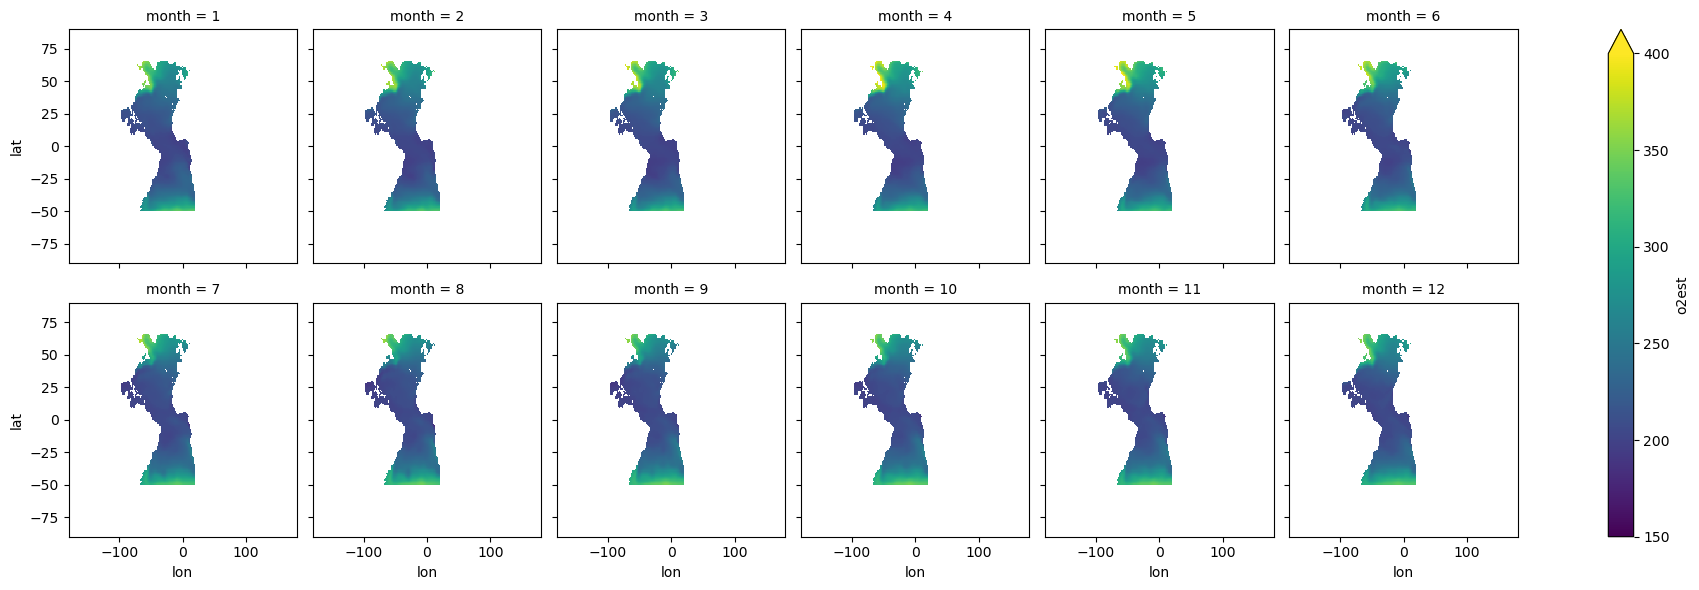

In [9]:
ds.o2est.groupby('time.month').mean('time').isel(depth=0).plot(col='month',col_wrap=6,vmin=150,vmax=400)

### Monthly climatology of WOA18

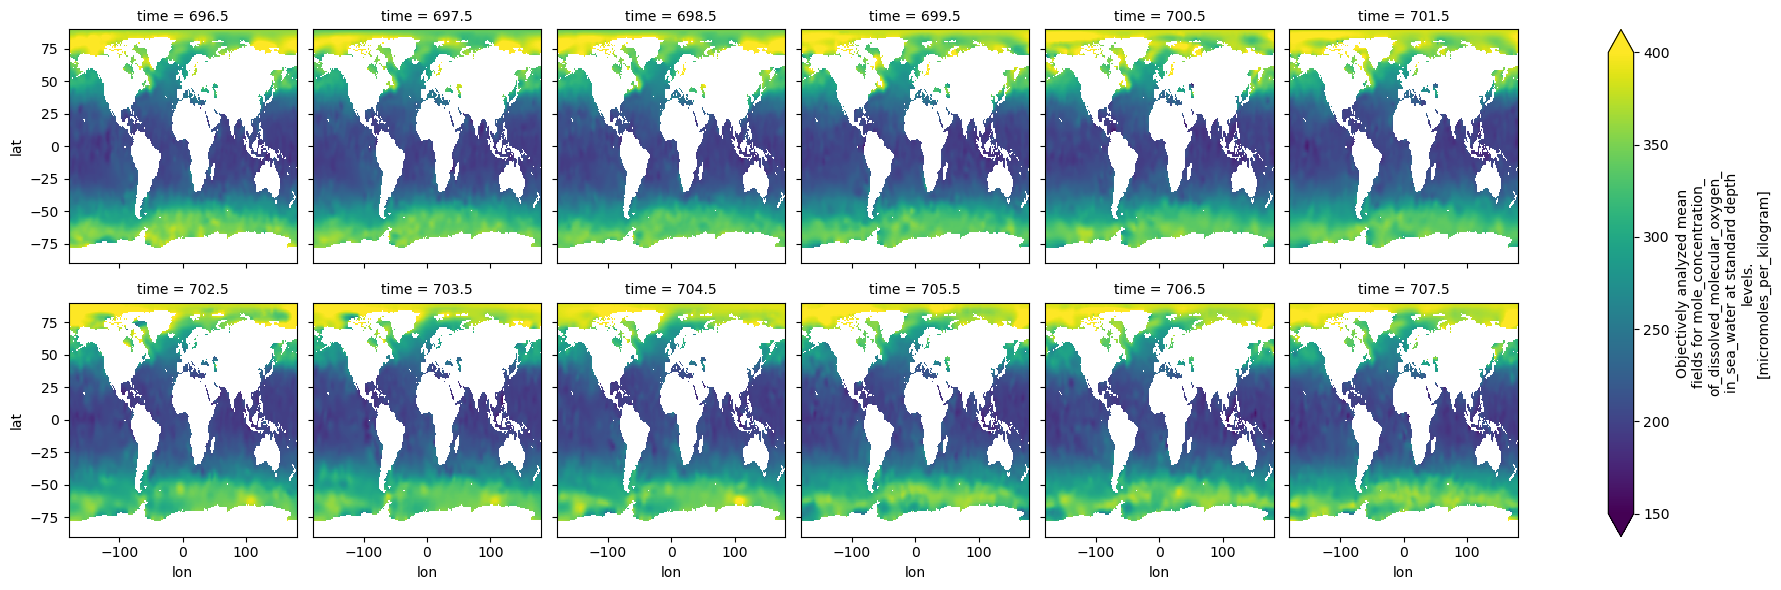

In [10]:
dc.o_an.isel(depth=0).plot(col='time',col_wrap=6,vmin=150,vmax=400)

### Difference (ML estimates) - (WOA)

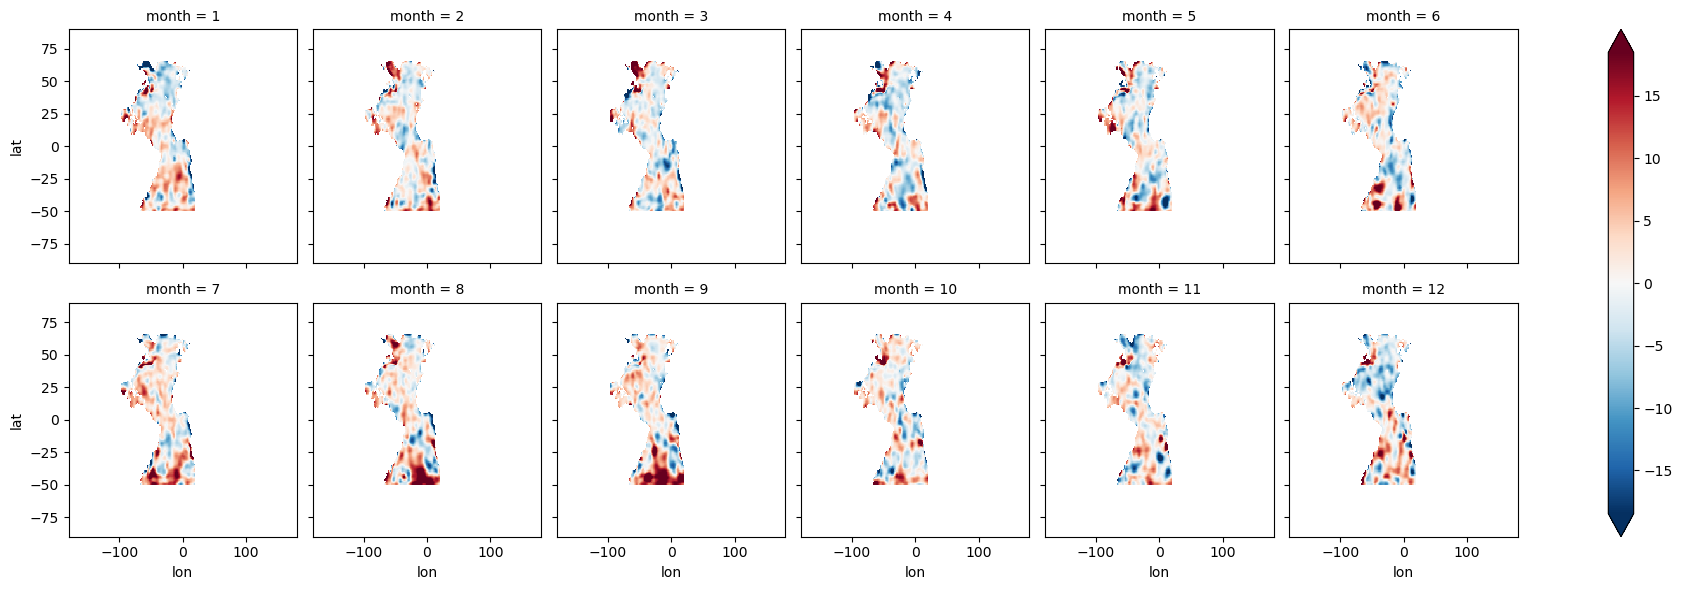

In [11]:
month=np.arange(1,13,1)
da=xr.DataArray(data=do2,dims=['month','lat','lon'],coords={'month':month,'lat':ds.lat,'lon':ds.lon})
da.plot(col='month',col_wrap=6,robust=True)

In [12]:
RMSE = np.sqrt(np.nanmean(do2**2))
print('RMSE='+str(RMSE)[:4])
#
in0 = ds.o2est.groupby('time.month').mean('time').isel(depth=0).to_numpy()
in1 = dc.o_an.isel(depth=0).to_numpy()
mask = np.isnan(in0+in1)==False
tmp = np.corrcoef(in0[mask].flatten(),in1[mask].flatten())
R = tmp[0,1]
print('R='+str(R)[:5])

RMSE=7.53
R=0.981


### Calculate time series

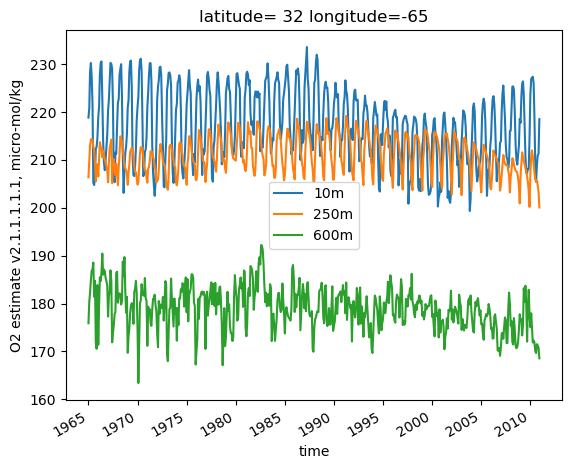

In [13]:
# extract a single grid cell
lon = -65
lat = 32
ds.o2est.sel(lon=lon,method='nearest').sel(lat=lat,method='nearest').sel(depth=10).plot(label='10m')
ds.o2est.sel(lon=lon,method='nearest').sel(lat=lat,method='nearest').sel(depth=250).plot(label='250m')
ds.o2est.sel(lon=lon,method='nearest').sel(lat=lat,method='nearest').sel(depth=600).plot(label='600m')
plt.title('latitude= '+str(lat)+' longitude='+str(lon))
plt.ylabel('O2 estimate v'+ver+', micro-mol/kg')
plt.legend()

In [14]:
# inventory trend
y = ds.lat
x = ds.lon
z = ds.depth
Nz=np.size(z)
z0=np.zeros(Nz+1)
z0[1:]=z
dz=np.diff(z0)
#
xx,yy=np.meshgrid(x,y)
R=6.37e6
darea=np.cos(yy*np.pi/180)*(R*np.pi/180)**2
dvo=np.zeros((Nz,180,360))
# volume element in 3D
for n in range(Nz):
    dvo[n,:,:]=darea*dz[n]
#
weight = dvo
dweight = xr.DataArray(data=weight,dims=['depth','lat','lon'],
                 coords={'depth':z,'lat':y,'lon':x})
o2invg = ds.o2est.weighted(dweight).sum('lon').sum('lat').sum('depth')*1e-6*1025 # convert to mol
o2ag = o2invg.groupby('time.month') - o2invg.groupby('time.month').mean('time') # calculate O2 inventory anomaly

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


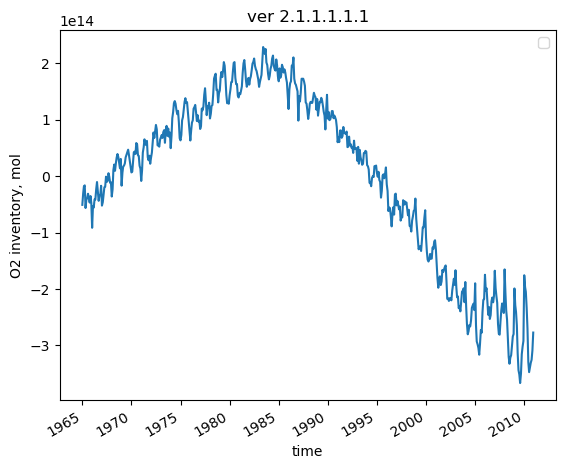

In [15]:
o2ag.plot()
plt.title('ver '+ver)
plt.ylabel('O2 inventory, mol')
plt.legend()